In [2]:
import os
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
from torch import nn,optim
from tqdm.notebook import tqdm
from torchvision import transforms, datasets

In [3]:
dogs = np.loadtxt('./cifar/dogs.csv',delimiter=',')

In [4]:
traindatanp = dogs.reshape(5000,3,32,32)
traindatanp = traindatanp.astype('float32')
traindata = torch.from_numpy(traindatanp)

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [113]:
M=100

In [114]:
class Generative(nn.Module):
    def __init__(self):
        super(Generative, self).__init__()
        
        self.main = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d(M, 64, 4, 1, 0, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                # state size. 256 x 4 x 4
                nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(True),
                # state size. 128 x 8 x 8
                nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                # state size. 64 x 16 x 16
                nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
                nn.Tanh()
                # state size. 3 x 32 x 32
            )
    
    def forward(self, x):
        return self.main(x)
    

In [115]:
class Discriminative(nn.Module):
    def __init__(self):
        super(Discriminative, self).__init__()
        
        self.main = nn.Sequential(
                # input is 3 x 32 x 32
                nn.Conv2d(3, 32, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 32 x 32 x 32
                nn.Conv2d(32, 64, 4, 2, 1, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 64 x 16 x 16
                nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 128 x 8 x 8
                nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 256 x 4 x 4
                nn.Conv2d(256, 1, 2, 1, 0, bias=False),
                nn.Sigmoid()
            )
    
    def forward(self, x):
        return self.main(x)

In [123]:
lr = 0.0002

disc = Discriminative()
disc.apply(weights_init)
disc_optimizer = optim.Adam(params=disc.parameters(), lr=lr, betas=(0.9,0.999))

loss = nn.BCELoss()

gen = Generative()
gen.apply(weights_init)
gen_optimizer = optim.Adam(params=gen.parameters(), lr=lr, betas=(0.9,0.999))

n_epochs = 100
batch_size=50
scale= 5
disc_optimizer.zero_grad()
slope = 1
old_mean_disc_loss, mean_disc_loss = 0,0
old_mean_gen_loss, mean_gen_loss=0,0
gen_avg=0
for e in tqdm(range(n_epochs)):
    if mean_disc_loss > 1.2*old_mean_disc_loss:
        slope -=1
        scale -=1
       
    if mean_gen_loss > 1.1*old_mean_gen_loss:
        slope += 1
        scale += 1
        
    print('scale = {}, slope = {}, mean disc_loss = {}, mean_gen_loss = {}, sum = {}, p={}'.format(scale, slope, mean_disc_loss,mean_gen_loss,mean_disc_loss+mean_gen_loss, gen_avg))
    print('old disc_loss = {}, old gen_loss = {}'.format( old_mean_disc_loss, old_mean_gen_loss))
  
    old_mean_disc_loss = mean_disc_loss
    old_mean_gen_loss = mean_gen_loss
    mean_disc_loss = 0
    mean_gen_loss = 0
    for i in tqdm(range(5000//batch_size)):
        
        real_images = traindata[(i*batch_size):((i+1)*batch_size)]
        
        

        # Define real_images, real_labels
        real_labels = torch.full((real_images.size(0),1), 1).view(batch_size)
        big_real_labels = torch.full((scale*real_images.size(0),1), 1).view(scale*batch_size)
        # Generate noise and define fake_labels
        noise_vectors = torch.randn(real_images.size(0), M, 1, 1)
        big_noise_vectors = torch.randn(scale*real_images.size(0),M,1,1)
        
        fake_labels = torch.full((real_images.size(0),1), 0).view(batch_size)
        big_fake_labels = torch.full((real_images.size(0)*scale,1),0).view(scale*batch_size)
        

        # Train discriminative network one step using batch of real images
        #real_images = real_images + (torch.randn(real_images.size())/10)
        output = disc(real_images).view(batch_size)

        real_loss = loss(output, real_labels)
        real_loss.backward()
        disc_real_avg = output.mean().item()

    
        # Generate fake images from noise and pass them through disc. net.
        fake_images = gen(noise_vectors)
        #fake_images = fake_images + (torch.randn(fake_images.size())/10)
        output = disc(fake_images.detach()).view(batch_size)
        fake_loss = loss(output, fake_labels)
        fake_loss.backward()

        # Aggregative real and fake loss and update weights
        step_loss = real_loss + fake_loss
        disc_fake_avg = output.mean().item()
        if i%slope ==0:
            disc_optimizer.step()
            disc_optimizer.zero_grad()

        # Train generative network
        gen_optimizer.zero_grad()
        big_fake_images = gen(big_noise_vectors)
        output = disc(big_fake_images).view(scale*batch_size)
        gen_loss = loss(output, big_real_labels)
        gen_loss.backward()
        gen_avg = output.mean().item()
        gen_optimizer.step()
        mean_disc_loss +=step_loss.item()
        mean_gen_loss += gen_loss.item()
        

        #if i % 10 == 0:
        #    print("Epoch: "+str(e+1)+" | Disc. Loss: "+str(step_loss.item())+" | Gen. Loss: "+str(gen_loss.item())+
         #       " | D(X): "+str(disc_real_avg)+" | D(G(Z)): "+str(disc_fake_avg)+" -> "+str(gen_avg))


scale = 5, slope = 1, mean disc_loss = 0, mean_gen_loss = 0, sum = 0, p=0
old gen_loss = 0, old disc_loss = 0


scale = 5, slope = 1, mean disc_loss = 86.10614162683487, mean_gen_loss = 72.82814252376556, sum = 158.93428415060043, p=0.4793335199356079
old gen_loss = 0, old disc_loss = 0


scale = 5, slope = 1, mean disc_loss = 76.12449318170547, mean_gen_loss = 70.13136804103851, sum = 146.255861222744, p=0.505925178527832
old gen_loss = 72.82814252376556, old disc_loss = 86.10614162683487


scale = 5, slope = 1, mean disc_loss = 74.67080682516098, mean_gen_loss = 69.5208551287651, sum = 144.1916619539261, p=0.5302504897117615
old gen_loss = 70.13136804103851, old disc_loss = 76.12449318170547


scale = 5, slope = 1, mean disc_loss = 71.83114814758301, mean_gen_loss = 69.39001381397247, sum = 141.22116196155548, p=0.48237329721450806
old gen_loss = 69.5208551287651, old disc_loss = 74.67080682516098


scale = 5, slope = 1, mean disc_loss = 70.63567501306534, mean_gen_loss = 69.13759785890579, sum = 139.77327287197113, p=0.5273953080177307
old gen_loss = 69.39001381397247, old disc_loss = 71.83114814758301


scale = 5, slope = 1, mean disc_loss = 69.82044416666031, mean_gen_loss = 69.59270298480988, sum = 139.41314715147018, p=0.4908432960510254
old gen_loss = 69.13759785890579, old disc_loss = 70.63567501306534


scale = 5, slope = 1, mean disc_loss = 69.95358628034592, mean_gen_loss = 69.33271300792694, sum = 139.28629928827286, p=0.4963732957839966
old gen_loss = 69.59270298480988, old disc_loss = 69.82044416666031


scale = 5, slope = 1, mean disc_loss = 69.28881198167801, mean_gen_loss = 69.08623832464218, sum = 138.3750503063202, p=0.5090082883834839
old gen_loss = 69.33271300792694, old disc_loss = 69.95358628034592


scale = 5, slope = 1, mean disc_loss = 69.59416282176971, mean_gen_loss = 69.28164553642273, sum = 138.87580835819244, p=0.49751782417297363
old gen_loss = 69.08623832464218, old disc_loss = 69.28881198167801


scale = 5, slope = 1, mean disc_loss = 69.22449320554733, mean_gen_loss = 69.45411688089371, sum = 138.67861008644104, p=0.4871067702770233
old gen_loss = 69.28164553642273, old disc_loss = 69.59416282176971


scale = 5, slope = 1, mean disc_loss = 69.91770941019058, mean_gen_loss = 69.65615347027779, sum = 139.57386288046837, p=0.5154849886894226
old gen_loss = 69.45411688089371, old disc_loss = 69.22449320554733


scale = 5, slope = 1, mean disc_loss = 69.19884043931961, mean_gen_loss = 69.16835278272629, sum = 138.3671932220459, p=0.496553510427475
old gen_loss = 69.65615347027779, old disc_loss = 69.91770941019058


scale = 5, slope = 1, mean disc_loss = 67.79932376742363, mean_gen_loss = 68.41540393233299, sum = 136.21472769975662, p=0.6089310050010681
old gen_loss = 69.16835278272629, old disc_loss = 69.19884043931961


scale = 5, slope = 1, mean disc_loss = 67.13376727700233, mean_gen_loss = 67.75935363769531, sum = 134.89312091469765, p=0.31309959292411804
old gen_loss = 68.41540393233299, old disc_loss = 67.79932376742363


scale = 5, slope = 1, mean disc_loss = 64.24309186637402, mean_gen_loss = 62.401135459542274, sum = 126.64422732591629, p=0.7298382520675659
old gen_loss = 67.75935363769531, old disc_loss = 67.13376727700233


scale = 5, slope = 1, mean disc_loss = 63.20006102323532, mean_gen_loss = 60.34108266234398, sum = 123.5411436855793, p=0.5009453296661377
old gen_loss = 62.401135459542274, old disc_loss = 64.24309186637402


scale = 5, slope = 1, mean disc_loss = 53.627728659659624, mean_gen_loss = 55.97142751514912, sum = 109.59915617480874, p=0.28939446806907654
old gen_loss = 60.34108266234398, old disc_loss = 63.20006102323532


scale = 5, slope = 1, mean disc_loss = 49.42661675810814, mean_gen_loss = 46.58711360767484, sum = 96.01373036578298, p=0.9384497404098511
old gen_loss = 55.97142751514912, old disc_loss = 53.627728659659624


scale = 5, slope = 1, mean disc_loss = 72.87484103441238, mean_gen_loss = 67.72352217882872, sum = 140.5983632132411, p=0.5468533039093018
old gen_loss = 46.58711360767484, old disc_loss = 49.42661675810814


scale = 5, slope = 1, mean disc_loss = 54.64213186688721, mean_gen_loss = 52.3861975595355, sum = 107.02832942642272, p=0.5414294600486755
old gen_loss = 67.72352217882872, old disc_loss = 72.87484103441238


scale = 5, slope = 1, mean disc_loss = 51.862579016014934, mean_gen_loss = 51.93024271726608, sum = 103.79282173328102, p=0.4593204855918884
old gen_loss = 52.3861975595355, old disc_loss = 54.64213186688721


scale = 5, slope = 1, mean disc_loss = 43.50185755267739, mean_gen_loss = 44.90285072103143, sum = 88.40470827370882, p=0.9087560176849365
old gen_loss = 51.93024271726608, old disc_loss = 51.862579016014934


scale = 5, slope = 1, mean disc_loss = 48.10461958497763, mean_gen_loss = 45.51424764841795, sum = 93.61886723339558, p=0.48130789399147034
old gen_loss = 44.90285072103143, old disc_loss = 43.50185755267739


scale = 5, slope = 1, mean disc_loss = 49.09483613818884, mean_gen_loss = 46.9454494677484, sum = 96.04028560593724, p=0.6885854005813599
old gen_loss = 45.51424764841795, old disc_loss = 48.10461958497763


scale = 5, slope = 1, mean disc_loss = 52.45545931532979, mean_gen_loss = 48.919125735759735, sum = 101.37458505108953, p=0.6138995289802551
old gen_loss = 46.9454494677484, old disc_loss = 49.09483613818884


scale = 5, slope = 1, mean disc_loss = 44.19833021610975, mean_gen_loss = 40.954914085567, sum = 85.15324430167675, p=0.7996436953544617
old gen_loss = 48.919125735759735, old disc_loss = 52.45545931532979


scale = 5, slope = 1, mean disc_loss = 35.880797293037176, mean_gen_loss = 39.623764134943485, sum = 75.50456142798066, p=0.8163917064666748
old gen_loss = 40.954914085567, old disc_loss = 44.19833021610975


scale = 6, slope = 2, mean disc_loss = 36.57149730809033, mean_gen_loss = 45.34080521017313, sum = 81.91230251826346, p=0.45060962438583374
old gen_loss = 39.623764134943485, old disc_loss = 35.880797293037176


scale = 6, slope = 2, mean disc_loss = 73.48913830518723, mean_gen_loss = 67.78989005088806, sum = 141.2790283560753, p=0.4896194040775299
old gen_loss = 45.34080521017313, old disc_loss = 36.57149730809033


scale = 6, slope = 2, mean disc_loss = 63.30781506001949, mean_gen_loss = 61.12998813390732, sum = 124.43780319392681, p=0.6651902198791504
old gen_loss = 67.78989005088806, old disc_loss = 73.48913830518723


scale = 6, slope = 2, mean disc_loss = 33.92800610885024, mean_gen_loss = 36.31761023774743, sum = 70.24561634659767, p=0.9396785497665405
old gen_loss = 61.12998813390732, old disc_loss = 63.30781506001949


scale = 6, slope = 2, mean disc_loss = 31.460310962051153, mean_gen_loss = 31.455373775213957, sum = 62.91568473726511, p=0.9511213302612305
old gen_loss = 36.31761023774743, old disc_loss = 33.92800610885024


scale = 6, slope = 2, mean disc_loss = 43.224803203716874, mean_gen_loss = 34.6955854203552, sum = 77.92038862407207, p=0.9086982011795044
old gen_loss = 31.455373775213957, old disc_loss = 31.460310962051153


scale = 6, slope = 2, mean disc_loss = 12.888575282879174, mean_gen_loss = 17.86496950685978, sum = 30.753544789738953, p=0.979354977607727
old gen_loss = 34.6955854203552, old disc_loss = 43.224803203716874


scale = 6, slope = 2, mean disc_loss = 18.653105756267905, mean_gen_loss = 23.038522460497916, sum = 41.69162821676582, p=0.8744374513626099
old gen_loss = 17.86496950685978, old disc_loss = 12.888575282879174


scale = 6, slope = 2, mean disc_loss = 18.491845276672393, mean_gen_loss = 20.243315015453845, sum = 38.73516029212624, p=0.6727213263511658
old gen_loss = 23.038522460497916, old disc_loss = 18.653105756267905


scale = 6, slope = 2, mean disc_loss = 29.833151614293456, mean_gen_loss = 29.38980793207884, sum = 59.222959546372294, p=0.9065483808517456
old gen_loss = 20.243315015453845, old disc_loss = 18.491845276672393


scale = 6, slope = 2, mean disc_loss = 21.89497232530266, mean_gen_loss = 25.73164400830865, sum = 47.62661633361131, p=0.9490306377410889
old gen_loss = 29.38980793207884, old disc_loss = 29.833151614293456


scale = 6, slope = 2, mean disc_loss = 12.256433269474655, mean_gen_loss = 14.383782342076302, sum = 26.640215611550957, p=0.9786762595176697
old gen_loss = 25.73164400830865, old disc_loss = 21.89497232530266


scale = 6, slope = 2, mean disc_loss = 33.089102901052684, mean_gen_loss = 34.69888904411346, sum = 67.78799194516614, p=0.9703420996665955
old gen_loss = 14.383782342076302, old disc_loss = 12.256433269474655


scale = 6, slope = 2, mean disc_loss = 18.43251280579716, mean_gen_loss = 20.878392711747438, sum = 39.3109055175446, p=0.9769874215126038
old gen_loss = 34.69888904411346, old disc_loss = 33.089102901052684


scale = 6, slope = 2, mean disc_loss = 14.88653343077749, mean_gen_loss = 15.834335203748196, sum = 30.720868634525687, p=0.985795795917511
old gen_loss = 20.878392711747438, old disc_loss = 18.43251280579716


scale = 7, slope = 3, mean disc_loss = 17.51698306342587, mean_gen_loss = 23.32720655295998, sum = 40.84418961638585, p=0.9172340035438538
old gen_loss = 15.834335203748196, old disc_loss = 14.88653343077749


scale = 7, slope = 3, mean disc_loss = 7.8882689736783504, mean_gen_loss = 10.144853660603985, sum = 18.033122634282336, p=0.9950467348098755
old gen_loss = 23.32720655295998, old disc_loss = 17.51698306342587


scale = 7, slope = 3, mean disc_loss = 11.403987548663281, mean_gen_loss = 11.94580456521362, sum = 23.3497921138769, p=0.9877034425735474
old gen_loss = 10.144853660603985, old disc_loss = 7.8882689736783504


scale = 7, slope = 3, mean disc_loss = 6.5515248734736815, mean_gen_loss = 11.3569299003575, sum = 17.90845477383118, p=0.9944139719009399
old gen_loss = 11.94580456521362, old disc_loss = 11.403987548663281


scale = 7, slope = 3, mean disc_loss = 4.023614319274202, mean_gen_loss = 3.3191030432935804, sum = 7.342717362567782, p=0.9919788241386414
old gen_loss = 11.3569299003575, old disc_loss = 6.5515248734736815


scale = 7, slope = 3, mean disc_loss = 16.875604864908382, mean_gen_loss = 14.672390920226462, sum = 31.547995785134844, p=0.9754566550254822
old gen_loss = 3.3191030432935804, old disc_loss = 4.023614319274202


scale = 7, slope = 3, mean disc_loss = 2.8794750990346074, mean_gen_loss = 5.370375869562849, sum = 8.249850968597457, p=0.9930543899536133
old gen_loss = 14.672390920226462, old disc_loss = 16.875604864908382


scale = 7, slope = 3, mean disc_loss = 3.3791527194553055, mean_gen_loss = 5.037200657301582, sum = 8.416353376756888, p=0.9950258135795593
old gen_loss = 5.370375869562849, old disc_loss = 2.8794750990346074


scale = 7, slope = 3, mean disc_loss = 10.662758438789751, mean_gen_loss = 6.080647362861782, sum = 16.743405801651534, p=0.9222010970115662
old gen_loss = 5.037200657301582, old disc_loss = 3.3791527194553055


scale = 8, slope = 4, mean disc_loss = 9.588255452807061, mean_gen_loss = 12.092692153528333, sum = 21.680947606335394, p=0.9885536432266235
old gen_loss = 6.080647362861782, old disc_loss = 10.662758438789751


scale = 8, slope = 4, mean disc_loss = 2.0122082722373307, mean_gen_loss = 3.130030234809965, sum = 5.142238507047296, p=0.9456678628921509
old gen_loss = 12.092692153528333, old disc_loss = 9.588255452807061


scale = 8, slope = 4, mean disc_loss = 1.8555035012541339, mean_gen_loss = 2.473454565508291, sum = 4.328958066762425, p=0.9903378486633301
old gen_loss = 3.130030234809965, old disc_loss = 2.0122082722373307


scale = 8, slope = 4, mean disc_loss = 1.123796492931433, mean_gen_loss = 1.4522908506914973, sum = 2.5760873436229303, p=0.9910385012626648
old gen_loss = 2.473454565508291, old disc_loss = 1.8555035012541339


scale = 8, slope = 4, mean disc_loss = 1.5180972915841267, mean_gen_loss = 2.1771287855226547, sum = 3.6952260771067813, p=0.9988365173339844
old gen_loss = 1.4522908506914973, old disc_loss = 1.123796492931433


scale = 8, slope = 4, mean disc_loss = 13.271140761265997, mean_gen_loss = 12.418965806951746, sum = 25.690106568217743, p=0.7575713992118835
old gen_loss = 2.1771287855226547, old disc_loss = 1.5180972915841267


scale = 8, slope = 4, mean disc_loss = 3.852683016215451, mean_gen_loss = 3.9840372807811946, sum = 7.836720296996646, p=0.9929165840148926
old gen_loss = 12.418965806951746, old disc_loss = 13.271140761265997


scale = 8, slope = 4, mean disc_loss = 5.762892702012323, mean_gen_loss = 5.66725378902629, sum = 11.430146491038613, p=0.9865490794181824
old gen_loss = 3.9840372807811946, old disc_loss = 3.852683016215451


scale = 8, slope = 4, mean disc_loss = 1.9820020112092607, mean_gen_loss = 3.01606947183609, sum = 4.998071483045351, p=0.9936310648918152
old gen_loss = 5.66725378902629, old disc_loss = 5.762892702012323


scale = 8, slope = 4, mean disc_loss = 0.7279259940842167, mean_gen_loss = 0.8997709713876247, sum = 1.6276969654718414, p=0.9953066110610962
old gen_loss = 3.01606947183609, old disc_loss = 1.9820020112092607


scale = 8, slope = 4, mean disc_loss = 1.6042491387343034, mean_gen_loss = 2.5336599708534777, sum = 4.137909109587781, p=0.7150937914848328
old gen_loss = 0.8997709713876247, old disc_loss = 0.7279259940842167


scale = 8, slope = 4, mean disc_loss = 11.957478931872174, mean_gen_loss = 9.985303021443542, sum = 21.942781953315716, p=0.984394371509552
old gen_loss = 2.5336599708534777, old disc_loss = 1.6042491387343034


scale = 8, slope = 4, mean disc_loss = 2.5129226641147397, mean_gen_loss = 3.8638887759880163, sum = 6.376811440102756, p=0.9947109222412109
old gen_loss = 9.985303021443542, old disc_loss = 11.957478931872174


scale = 8, slope = 4, mean disc_loss = 3.4012307917582802, mean_gen_loss = 9.478694668388925, sum = 12.879925460147206, p=0.9905153512954712
old gen_loss = 3.8638887759880163, old disc_loss = 2.5129226641147397


scale = 8, slope = 4, mean disc_loss = 1.7852684190147556, mean_gen_loss = 1.9367917976342142, sum = 3.72206021664897, p=0.993410587310791
old gen_loss = 9.478694668388925, old disc_loss = 3.4012307917582802


scale = 8, slope = 4, mean disc_loss = 4.341927713016048, mean_gen_loss = 9.749034571577795, sum = 14.090962284593843, p=0.9556544423103333
old gen_loss = 1.9367917976342142, old disc_loss = 1.7852684190147556


scale = 8, slope = 4, mean disc_loss = 1.6437183148227632, mean_gen_loss = 2.1600525743560866, sum = 3.8037708891788498, p=0.9988521337509155
old gen_loss = 9.749034571577795, old disc_loss = 4.341927713016048


scale = 8, slope = 4, mean disc_loss = 0.5577890053973533, mean_gen_loss = 0.8267960147932172, sum = 1.3845850201905705, p=0.9979963898658752
old gen_loss = 2.1600525743560866, old disc_loss = 1.6437183148227632


scale = 8, slope = 4, mean disc_loss = 1.511832028743811, mean_gen_loss = 1.3514236578484997, sum = 2.8632556865923107, p=0.963351845741272
old gen_loss = 0.8267960147932172, old disc_loss = 0.5577890053973533


scale = 8, slope = 4, mean disc_loss = 4.719394728075713, mean_gen_loss = 7.9657347536413, sum = 12.685129481717013, p=0.8597418069839478
old gen_loss = 1.3514236578484997, old disc_loss = 1.511832028743811


scale = 8, slope = 4, mean disc_loss = 4.041287383297458, mean_gen_loss = 5.98263622057857, sum = 10.023923603876028, p=0.9926641583442688
old gen_loss = 7.9657347536413, old disc_loss = 4.719394728075713


scale = 7, slope = 3, mean disc_loss = 8.330810171144549, mean_gen_loss = 6.555633980955463, sum = 14.886444152100012, p=0.9967255592346191
old gen_loss = 5.98263622057857, old disc_loss = 4.041287383297458


scale = 8, slope = 4, mean disc_loss = 4.3138951937435195, mean_gen_loss = 12.747303638898302, sum = 17.06119883264182, p=0.9794235825538635
old gen_loss = 6.555633980955463, old disc_loss = 8.330810171144549


scale = 8, slope = 4, mean disc_loss = 1.7753552450449206, mean_gen_loss = 1.9203696752083488, sum = 3.6957249202532694, p=0.9737921953201294
old gen_loss = 12.747303638898302, old disc_loss = 4.3138951937435195


scale = 9, slope = 5, mean disc_loss = 1.2830044170841575, mean_gen_loss = 5.929253184353001, sum = 7.212257601437159, p=0.9977051615715027
old gen_loss = 1.9203696752083488, old disc_loss = 1.7753552450449206


scale = 9, slope = 5, mean disc_loss = 44.5625013752142, mean_gen_loss = 30.286938335280865, sum = 74.84943971049506, p=0.9614133834838867
old gen_loss = 5.929253184353001, old disc_loss = 1.2830044170841575


scale = 9, slope = 5, mean disc_loss = 16.718668440473266, mean_gen_loss = 14.463266534963623, sum = 31.18193497543689, p=0.9506317973136902
old gen_loss = 30.286938335280865, old disc_loss = 44.5625013752142


scale = 9, slope = 5, mean disc_loss = 5.302794212475419, mean_gen_loss = 7.800182917155325, sum = 13.102977129630744, p=0.9952279329299927
old gen_loss = 14.463266534963623, old disc_loss = 16.718668440473266


scale = 9, slope = 5, mean disc_loss = 6.606569396972191, mean_gen_loss = 22.647427935153246, sum = 29.253997332125437, p=0.8526994585990906
old gen_loss = 7.800182917155325, old disc_loss = 5.302794212475419


scale = 8, slope = 4, mean disc_loss = 11.941870950045995, mean_gen_loss = 7.8428605913650244, sum = 19.78473154141102, p=0.9455698132514954
old gen_loss = 22.647427935153246, old disc_loss = 6.606569396972191


scale = 8, slope = 4, mean disc_loss = 8.894238478620537, mean_gen_loss = 6.4786918552126735, sum = 15.37293033383321, p=0.7913497090339661
old gen_loss = 7.8428605913650244, old disc_loss = 11.941870950045995


scale = 8, slope = 4, mean disc_loss = 3.3907894345466048, mean_gen_loss = 6.679742416832596, sum = 10.0705318513792, p=0.9959866404533386
old gen_loss = 6.4786918552126735, old disc_loss = 8.894238478620537


scale = 8, slope = 4, mean disc_loss = 11.171542650670744, mean_gen_loss = 14.982450747105759, sum = 26.153993397776503, p=0.9926904439926147
old gen_loss = 6.679742416832596, old disc_loss = 3.3907894345466048


scale = 8, slope = 4, mean disc_loss = 5.512471712660044, mean_gen_loss = 4.3524537538178265, sum = 9.864925466477871, p=0.9975612759590149
old gen_loss = 14.982450747105759, old disc_loss = 11.171542650670744


scale = 9, slope = 5, mean disc_loss = 3.7240382847376168, mean_gen_loss = 5.556225273932796, sum = 9.280263558670413, p=0.9981890916824341
old gen_loss = 4.3524537538178265, old disc_loss = 5.512471712660044


scale = 9, slope = 5, mean disc_loss = 3.3286650630179793, mean_gen_loss = 2.459982607048005, sum = 5.788647670065984, p=0.9916284680366516
old gen_loss = 5.556225273932796, old disc_loss = 3.7240382847376168


scale = 9, slope = 5, mean disc_loss = 1.0156853326479904, mean_gen_loss = 1.7800550273386762, sum = 2.7957403599866666, p=0.9985380172729492
old gen_loss = 2.459982607048005, old disc_loss = 3.3286650630179793


scale = 9, slope = 5, mean disc_loss = 2.2463825180602726, mean_gen_loss = 3.720124165934976, sum = 5.966506683995249, p=0.9288164377212524
old gen_loss = 1.7800550273386762, old disc_loss = 1.0156853326479904


scale = 10, slope = 6, mean disc_loss = 1.6146861021989025, mean_gen_loss = 7.105993135308381, sum = 8.720679237507284, p=0.9185657501220703
old gen_loss = 3.720124165934976, old disc_loss = 2.2463825180602726


scale = 9, slope = 5, mean disc_loss = 1.9933770708739758, mean_gen_loss = 1.3401841191225685, sum = 3.3335611899965443, p=0.997592568397522
old gen_loss = 7.105993135308381, old disc_loss = 1.6146861021989025


scale = 9, slope = 5, mean disc_loss = 0.39509704752708785, mean_gen_loss = 0.5633485575672239, sum = 0.9584456050943118, p=0.9987094402313232
old gen_loss = 1.3401841191225685, old disc_loss = 1.9933770708739758


scale = 9, slope = 5, mean disc_loss = 0.37868693537893705, mean_gen_loss = 0.48727054573828354, sum = 0.8659574811172206, p=0.9901604652404785
old gen_loss = 0.5633485575672239, old disc_loss = 0.39509704752708785


scale = 9, slope = 5, mean disc_loss = 0.30705174151808023, mean_gen_loss = 0.5028190585435368, sum = 0.809870800061617, p=0.9933284521102905
old gen_loss = 0.48727054573828354, old disc_loss = 0.37868693537893705


scale = 9, slope = 5, mean disc_loss = 0.5862806082004681, mean_gen_loss = 1.538054566422943, sum = 2.124335174623411, p=0.9979905486106873
old gen_loss = 0.5028190585435368, old disc_loss = 0.30705174151808023


scale = 9, slope = 5, mean disc_loss = 5.357922734983731, mean_gen_loss = 7.122614131076261, sum = 12.480536866059992, p=0.999119222164154
old gen_loss = 1.538054566422943, old disc_loss = 0.5862806082004681


scale = 9, slope = 5, mean disc_loss = 1.1185923600569367, mean_gen_loss = 0.6168322030571289, sum = 1.7354245631140657, p=0.9987605810165405
old gen_loss = 7.122614131076261, old disc_loss = 5.357922734983731


scale = 10, slope = 6, mean disc_loss = 0.7758298320986796, mean_gen_loss = 1.0850735442363657, sum = 1.8609033763350453, p=0.9959620237350464
old gen_loss = 0.6168322030571289, old disc_loss = 1.1185923600569367


scale = 10, slope = 6, mean disc_loss = 0.32502146750630345, mean_gen_loss = 0.702522731909994, sum = 1.0275441994162975, p=0.9986706376075745
old gen_loss = 1.0850735442363657, old disc_loss = 0.7758298320986796


In [134]:
noise = torch.randn(10, 100, 1, 1)
imgs = gen(noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


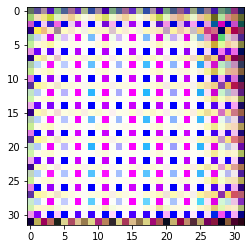

In [135]:
plt.imshow(imgs[0,:,:,:].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


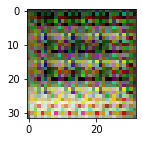

In [156]:
fig,axes = plt.subplots(1,figsize=(2,2))
axes.imshow(imgs[7,:,:,:].detach().numpy().transpose(1,2,0))